<a href="https://colab.research.google.com/github/armiro/Dental-Caries-Classification/blob/master/dental_caries_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras.backend as K
print('TensorFlow version is', tf.__version__)

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Concatenate, Activation
from tensorflow.keras import Model, optimizers

import os, glob, numpy as np, time, shutil, pickle, matplotlib.pyplot as plt, cv2, zipfile

next_init_epoch = 0

# see the provided CPU/GPU devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
!pip install keras_lr_finder
# !pip show keras_lr_finder

In [0]:
import numpy as np
import copy


def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi


def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf


def BEASF(image, gamma):
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

In [0]:
# image data preparation from uploaded folders
path = './drive/My Drive/Datasets/panoramic_dataset/healthy/*'
neg_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  neg_images.append(img)

neg_images = np.array(neg_images)
print('num healthy images:', len(neg_images))

path = './drive/My Drive/Datasets/panoramic_dataset/caries/*'
pos_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  pos_images.append(img)

pos_images = np.array(pos_images)
print('num carious images:', len(pos_images))

neg_labels = [0 for _ in range(len(neg_images))]
pos_labels = [1 for _ in range(len(pos_images))]

X = np.concatenate((pos_images, neg_images))
y = np.array(pos_labels + neg_labels)

# pad the asymmetric images to have them all as squared
X_padded = list() 
for image in X:
  height, width = image.shape[:2]
  if width >= height:
    img_pd = np.pad(image.squeeze(), pad_width=((int((width-height)/2), int((width-height)/2)),(0, 0)), mode='constant')
  else:
    img_pd = np.pad(image.squeeze(), pad_width=((0, 0),(int((height-width)/2), int((height-width)/2))), mode='constant')
  X_padded.append(img_pd)
X = np.array(X_padded)

# resize images if pre-trained model is trained on specific input shape
X = np.array([cv2.resize(image, dsize=(300, 300), interpolation=cv2.INTER_CUBIC) for image in X])
X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
X = X.astype(dtype=np.uint8)

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X, X_beasf, X_clahe), axis=-1)

# do the rescaling
X = np.array([X[idx] / 255. for idx in range(len(X))])

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))
print('dataset shape:', X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

print('random image from the dataset:')
rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.show()

num healthy images: 591
num carious images: 223
num total dataset images: 814
num total dataset labels: 814
dataset shape: (814, 300, 300, 1)


In [0]:
# np.save(file='/content/drive/My Drive/Datasets/opg_v2_x.npy', arr=X)
# np.save(file='/content/drive/My Drive/Datasets/opg_v2_y.npy', arr=y)

num carious images: 319
num healthy images: 1519
num total dataset images: 1838
num total dataset labels: 1838
dataset shape: (1838, 300, 300, 1)
random image from the dataset:


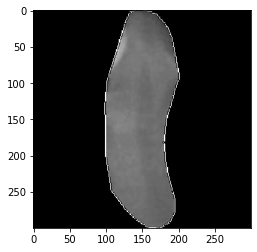

In [0]:
# image data preparation from saved npy files
X = np.load(file='/content/drive/My Drive/Datasets/panoramic_dataset/opg_v3_x.npy')
y = np.load(file='/content/drive/My Drive/Datasets/panoramic_dataset/opg_v3_y.npy')

num_carious_samples = 0
num_healthy_samples = 0
for idx, img in enumerate(X):
  if y[idx]:
    num_carious_samples += 1
  else:
    num_healthy_samples += 1
print('num carious images:', num_carious_samples)
print('num healthy images:', num_healthy_samples)

# apply image enhancements and concat with the original image
# X = np.array([BEASF(image=image, gamma=1.5) for image in X])
# X_clahe = np.array([cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)).apply(image) for image in X])
# X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
# X = np.concatenate((X, X_beasf, X_clahe), axis=-1)

# do the rescaling
X = np.array([X[idx] / 255. for idx in range(len(X))])

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))
print('dataset shape:', X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

print('random image from the dataset:')
rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.show()

In [0]:
img_indices = np.random.randint(low=0, high=len(X), size=10)
for img_idx in img_indices:
  plt.imshow(X[img_idx].squeeze(), cmap='gray')
  plt.show()

In [0]:
# dealing with data imbalance problem: resampling
# note: resampling must be done after train/test split, because doing that before it
# may result in having same sample both in training and test sets which causes overfitting!
from sklearn.utils import resample

pos_upsampled_train = resample(X_train[y_train == 1], n_samples=len(X_train[y_train == 0]), 
                               replace=True, random_state=20)
pos_upsampled_test = resample(X_test[y_test == 1], n_samples=len(X_test[y_test == 0]),
                              replace=True, random_state=20)

X_train_resampled = np.concatenate((X_train[y_train == 0], pos_upsampled_train))
X_test_resampled = np.concatenate((X_test[y_test == 0], pos_upsampled_test))
y_train_resampled = np.concatenate(([0 for _ in range(len(X_train[y_train == 0]))], 
                                    [1 for _ in range(len(X_train[y_train == 0]))]))
y_test_resampled = np.concatenate(([0 for _ in range(len(X_test[y_test == 0]))], 
                                   [1 for _ in range(len(X_test[y_test == 0]))]))

print('num resampled training-set samples:', len(X_train_resampled))
print('num resampled test-set samples:', len(X_test_resampled))

num resampled training-set samples: 2416
num resampled test-set samples: 622


In [0]:
aug = ImageDataGenerator(rescale=None, rotation_range=90, zoom_range=[0.75, 1.25], 
                         width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.15, horizontal_flip=True, 
                         vertical_flip=True, zca_whitening=False, fill_mode='nearest')

# test_aug = ImageDataGenerator(rescale=None)

In [0]:
def create_model():
  image_in = Input(shape=X_train[0].shape, name='input')
  x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv1')(image_in)
  x0 = BatchNormalization(momentum=0.90, name='bn1')(x)
  x1 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp1')(x0)
  x2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv2')(x1)
  x2 = BatchNormalization(momentum=0.90, name='bn2')(x2)
  x3 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp2')(x2)
  x4 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv3')(x3)
  x4 = BatchNormalization(momentum=0.90, name='bn3')(x4)
  x5 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp3')(x4)
  x6 = Flatten(name='flatten')(x5)
  x7 = Dense(units=50, activation='relu', name='fc1')(x6)
  # x7 = Dropout(rate=0.1)(x7)
  x8 = Dense(units=20, activation='relu', name='fc2')(x7)
  # x8 = Dropout(rate=0.1)(x8)
  x9 = Dense(units=10, activation='relu', name='fc3')(x8)
  x10 = Dense(units=1, activation='sigmoid', name='output')(x9)
  return Model(inputs=image_in, outputs=x10, name='binary_classifier')

classifier = create_model()
custom_opt = optimizers.Adam(learning_rate=0.005)
classifier.compile(optimizer=custom_opt, loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()
print('Num network layers:', len(classifier.layers))

In [0]:
# find the best learning rate for the model compiled by a predetermined optimizer
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model=classifier)
lr_finder.find(X_train_resampled, y_train_resampled, 0.000001, 10, 512, 50)
# best lr is where the plot has highest decreasing slope before the loss jump
lr_finder.plot_loss()

In [0]:
def get_last_weights(folder):
  """
  find last saved weights file and its epoch number
  :param folder: string
  :return: int, string
  """
  num_epochs = list()
  for weights_file in glob.glob(folder + '/**.hdf5'):
    num_epoch = int(weights_file[weights_file.find('=')+1:weights_file.find('_')])
    num_epochs.append((num_epoch, weights_file))

  last_epoch = max(num_epochs)[0]
  print('last saved epoch:', last_epoch)
  last_file = max(num_epochs)[1]
  print('last saved file:', last_file)
  return last_epoch, last_file


def delete_other_weights(folder, last_file):
  """
  delete all weights files saved before, except the last one which is the best
  :param folder: string
  :param last_file: string
  :return None
  """

  for weights_file in os.listdir(folder):
    if weights_file.endswith('.hdf5'):
      file_path = os.path.join(folder, weights_file)
      if file_path != last_file:
        try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
          elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
        except Exception as e:
          print('failed to delete %s. because of: %s' % (file_path, e))
      else:
        pass
  print('deleted all weights files saved before, except the last one.')


def save_obj(obj, name):
  with open('/'+ name + '.pkl', 'wb+') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
  with open('/' + name + '.pkl', 'rb') as f:
    return pickle.load(f)

In [0]:
# load the last saved weigths file as the model's weights and delete others
# run it ONLY if Google Colab stopped in the middle of model training
weights_folder = '/content/drive/My Drive/model'
next_init_epoch, last_epoch_weights_file = get_last_weights(weights_folder)
classifier.load_weights(last_epoch_weights_file)
delete_other_weights(folder=weights_folder, last_file=last_epoch_weights_file)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

file_path = '/content/drive/My Drive/model/eps={epoch:03d}_valAcc={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

cb_list = [checkpoint]

In [0]:
training = classifier.fit(x=aug.flow(x=X_train_resampled, y=y_train_resampled, batch_size=32), 
                          callbacks=cb_list, initial_epoch=next_init_epoch, verbose=1, epochs=50, 
                          validation_data=(X_test_resampled, y_test_resampled),
                          steps_per_epoch=int(len(X_train_resampled)/32), validation_steps=None)

# path = '/content/drive/My Drive/model/'
# save_obj(obj=training.history, name=path+'training_history')

In [0]:
path = '/content/drive/My Drive/model/'
# training_his = load_obj(name=path+'training_history')
fig = plt.figure()
plt.plot(training.history['loss'], color='r', label='training_loss')
# plt.plot(training_his['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
# plt.plot(training_his['val_loss'], color='g', label='val_loss')
plt.legend()
plt.show()
fig.savefig(path+'training_history_beasf.png')

In [0]:
# save the final best weights and delete others (after training is finished)
weights_folder = '/content/drive/My Drive/model'
_, best_weights = get_last_weights(weights_folder)
acc = float(best_weights[best_weights.rfind('=')+1:best_weights.rfind('.')])
print('best validation accuracy:', acc)
classifier.load_weights(best_weights)
delete_other_weights(folder=weights_folder, last_file=best_weights)

In [0]:
classifier.load_weights('/content/drive/My Drive/model/eps=566_valAcc=0.7793.hdf5')

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test_resampled, steps=len(X_test_resampled))

print('num images:', len(y_test_resampled))
print(y_test_resampled)

y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
print(y_pred)
y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
# print(y_pred_rnd)
cm = confusion_matrix(y_true=y_test_resampled, y_pred=y_pred_rnd)
print(cm)
print('acc:', (cm[0][0] + cm[1][1])/np.sum(cm))

In [0]:
# save the model architecture and dataset as json and zip/npy files
model_json = classifier.to_json()
with open("./drive/My Drive/model/model.json", "w") as json_file:
    json_file.write(model_json)

shutil.make_archive(base_name='./drive/My Drive/dataset', format='zip', 
                    base_dir='./drive/My Drive/Datasets/panoramic_dataset/')
# np.save(file='./drive/My Drive/dataset.npy', arr='./drive/My Drive/dataset.zip')

In [0]:
#####################################

In [0]:
# "keras-vis" library used for saliency map, only works with scipy<=1.3.0
!pip install vis
!pip show vis
# !pip show pillow
!pip install scipy==1.1.0
!pip show scipy

probability: [[0.3608321]]
probability: [[0.47909716]]
probability: [[0.06575596]]
probability: [[0.9998547]]


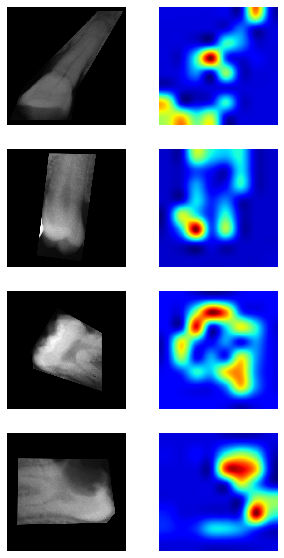

In [0]:
# draw the saliency map of the network (grad-CAM)
from vis.visualization import visualize_cam
# from vis.utils import utils
# from keras import activations
# import warnings
# warnings.filterwarnings('ignore')

img_indices = np.random.randint(low=0, high=len(X_train), size=4)

plt.rcParams["figure.figsize"] = (5,10)
f, ax = plt.subplots(len(img_indices), 2)

for i, img_idx in enumerate(img_indices):
  this_img = np.array(X_train[img_idx] / 255.)
  ax[i][0].imshow(this_img.squeeze(), cmap='gray', vmin=0, vmax=1)
  ax[i][0].axis('off')
  saliency_map = visualize_cam(net, layer_idx=-1, filter_indices=None, seed_input=this_img, 
                               backprop_modifier=None)       
  ax[i][1].imshow(saliency_map, cmap='jet')
  ax[i][1].axis('off')
  print('probability:', net.predict(np.expand_dims(this_img, axis=0)))


In [0]:
# ONLY if visualize_saliency is to be imported from vis.visualization
!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

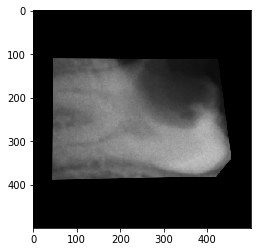

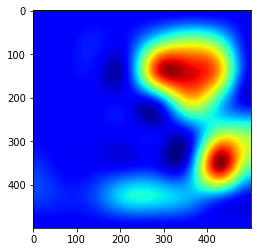

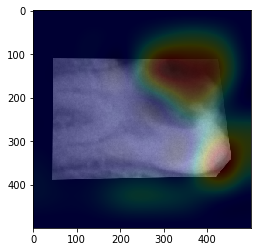

[[0.9998547]]
1


In [0]:
from vis.visualization import visualize_cam, overlay
from vis.utils import utils
# from vis.visualization import visualize_saliency
import matplotlib.cm as cm

IMG_IDX = 98
test_img = np.array(X_train[IMG_IDX] / 255.)
layer_idx = utils.find_layer_idx(model=net, layer_name='output')

plt.imshow(test_img.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()

grads = visualize_cam(model=net, layer_idx=layer_idx, filter_indices=None, seed_input=test_img,
                      penultimate_layer_idx=None, backprop_modifier=None, grad_modifier=None)
# s_map = visualize_saliency(net, -1, None, test_img, grad_modifier='invert')
plt.imshow(grads, cmap='jet')
plt.show()

jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
# print(jet_heatmap.shape)
ch_test_img = np.concatenate((X_train[IMG_IDX], X_train[IMG_IDX], X_train[IMG_IDX]), axis=-1)
# print(ch_test_img.shape)
plt.imshow(overlay(jet_heatmap, ch_test_img, alpha=0.2))
plt.show()

print(net.predict(np.expand_dims(test_img, axis=0)))
print(y_train[IMG_IDX])